In [1]:
import cv2
from fastai.core import *
from fastai.vision import *
from fastai.utils import show_install
from facenet_pytorch import MTCNN
from kgl_deepfake.nb_00 import *
from kgl_deepfake.nb_01a import *
from kgl_deepfake.nb_02a import *
from kgl_deepfake.nb_03 import *

In [4]:
#show_install()

In [2]:
SOURCE = Path('../data/train_sample_videos/')

In [3]:
fnames = get_files(SOURCE, extensions=['.mp4'])
fnames[:3]

[PosixPath('../data/train_sample_videos/cdaxixbosp.mp4'),
 PosixPath('../data/train_sample_videos/btiysiskpf.mp4'),
 PosixPath('../data/train_sample_videos/clihsshdkq.mp4')]

In [4]:
f = get_files(SOURCE, extensions=['.json'])[0]
annots = pd.read_json(f).T
annots.reset_index(inplace=True)
annots.rename({'index':'fname'}, axis=1, inplace=True)
annots.head()

,fname,label,split,original
0,aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
1,aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
2,abarnvbtwb.mp4,REAL,train,None
3,abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
4,abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


In [5]:
fnames = [SOURCE/o for o in annots.fname.values]

In [10]:
_dict_fname2label = {fname.split('.')[0]:label for fname, label in zip(annots.fname, annots.label)}

In [37]:
class FaceVideoList(ImageList):
    def __init__(self, *args, device=None, detector=None, resize=None, **kwargs):
        if device is None: device = 'gpu' if torch.cuda.is_available() else 'cpu'
        if detector is None: detector = MTCNN(device=device, post_process=False)
        self.detector, self.resize = detector, resize
        self.facepipe = DetectionPipeline(detector, n_frames=20, resize=resize) # if n_frames == 1, a face might not be guaranteed?
        super().__init__(*args, **kwargs)
        
    def get_a_face(self, fn):
        return self.facepipe(str(fn))[0]
    
    def open(self, fn): return Image(self.get_a_face(fn) / 255.)

In [43]:
%%time
src = FaceVideoList(fnames, path='./', resize=.5).split_by_rand_pct()

CPU times: user 39.5 ms, sys: 24.2 ms, total: 63.7 ms
Wall time: 88.8 ms


CPU times: user 26.5 s, sys: 9.15 s, total: 35.7 s
Wall time: 40.2 s


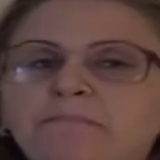

In [44]:
%%time
src.valid[19]

In [45]:
src.train.items[4].stem

'abqwwspghj'

In [46]:
%%time
data = src.label_from_func(lambda o: _dict_fname2label[o.stem])

CPU times: user 1.93 ms, sys: 2.8 ms, total: 4.73 ms
Wall time: 6.06 ms


In [40]:
sz = 128

In [47]:
%%time
data = data.transform(None, size=sz)

CPU times: user 39.6 s, sys: 22 s, total: 1min 1s
Wall time: 1min 18s


In [48]:
bs = 32

In [49]:
%%time
data = data.databunch(bs=bs, num_workers=0)

You can deactivate this warning by passing `no_check=True`.
CPU times: user 11min 10s, sys: 5min 1s, total: 16min 12s
Wall time: 19min 9s


/Users/jack/anaconda3/envs/fastai_dev/lib/python3.7/site-packages/fastai/basic_data.py:261: UserWarning: There seems to be something wrong with your dataset, for example, in the first batch can't access these elements in self.train_ds: 185,154
  warn(warn_msg)


In [50]:
data.train_ds[154]

TypeError: unsupported operand type(s) for /: 'NoneType' and 'float'